In [1]:
import pandas as pd
import plotly.express as px

## Reading extracted videoInfo

In [2]:
videos_df = pd.read_csv("outputs/videoInfo.csv")
videos_df = videos_df.drop(columns=["tags"]).drop_duplicates()
videos_df.dtypes

videoId                object
channelTitle           object
title                  object
description            object
publishedAt            object
duration              float64
definition             object
caption                  bool
viewCount             float64
likeCount             float64
favoriteCount         float64
commentCount          float64
publishedAtWeekday     object
publishedAtDay         object
publishedAtHour         int64
dtype: object

In [3]:
videos_df.shape

(1215, 15)

## Numeric columns to explore

In [4]:
selected_vars = [
    "videoId",
    "channelTitle",
    "title",
    "duration",
    "viewCount",
    "likeCount",
    "commentCount",
    "publishedAtDay",
    "publishedAtWeekday",
    "publishedAtHour"
    ]

videos_df = videos_df[selected_vars]
videos_df["shorts"] = videos_df["title"].map(lambda x: 1 if "#shorts" in x else 0)
videos_df["percInteraction"] = videos_df["commentCount"]/videos_df["viewCount"]
videos_df["percLike"] = videos_df["likeCount"]/videos_df["viewCount"]
videos_df["ratioLikeComment"] = videos_df["likeCount"]/videos_df["commentCount"]

videos_df.head()

,videoId,channelTitle,title,duration,viewCount,likeCount,commentCount,publishedAtDay,publishedAtWeekday,publishedAtHour,shorts,percInteraction,percLike,ratioLikeComment
0,7Bt7XLWIwOI,Graham Stephan,The Biggest Market Crash Of Our Generation Is ...,896.0,25981.0,2109.0,389.0,2022-07-11,Monday,22,0,0.014972,0.081175,5.421594
1,IQe4LqIODoA,Graham Stephan,The Housing Market Bubble Just Popped,727.0,440063.0,20145.0,1841.0,2022-07-08,Friday,22,0,0.004183,0.045778,10.942423
2,Qdwy6IyZVTc,Graham Stephan,An URGENT Warning For ALL Crypto Investors,794.0,336090.0,14612.0,1498.0,2022-07-06,Wednesday,21,0,0.004457,0.043476,9.754339
3,qYHVv3YwHMc,Graham Stephan,The Mother Of All Crashes Is Coming | Michael ...,775.0,677600.0,29372.0,1602.0,2022-07-01,Friday,20,0,0.002364,0.043347,18.334582
4,YGq_o-p_i8I,Graham Stephan,The Car Market Bubble Just Popped,782.0,1133545.0,47011.0,2762.0,2022-06-29,Wednesday,21,0,0.002437,0.041473,17.020637


## Selecting classic long videos

In [5]:
videos_df.groupby(["channelTitle", "shorts"])[["videoId"]].count()

videoId
channelTitle   shorts         
Andrei Jikh    0           368
               1            47
Graham Stephan 0           794
               1             6

In [6]:
mask = videos_df.shorts == 1
short_videos = videos_df[mask]
long_videos = videos_df[~mask]

## Distribution between Numbers of Views and Video Duration [s]

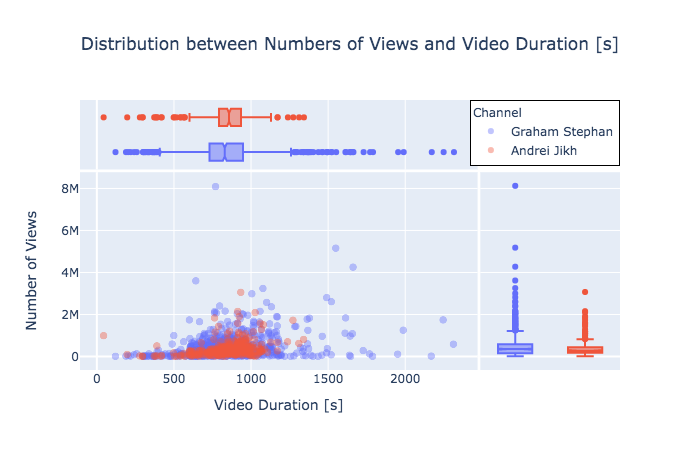

In [7]:
fig = px.scatter(long_videos[(long_videos.viewCount < 10E6) & (long_videos.duration < 3E3)],
                 x = "duration", y = "viewCount", color = "channelTitle",
                 opacity = 0.4,
                 marginal_x = "box",
                 marginal_y = "box",
                 labels={
                     "duration": "Video Duration [s]",
                     "viewCount": "Number of Views",
                     "channelTitle": "Channel"
                 },
                 title="Distribution between Numbers of Views and Video Duration [s]")
fig.update_layout(title_x=0.5, legend=dict(x = 0.722, y = 1, bordercolor = "Black", borderwidth = 1))
fig.show("png")

# Plotting timeseries to different numeric stats using Rolling Windows for smoothing the curves

Rolling Windows set in 14 days

In [8]:
daily_long_videos = long_videos.groupby(["channelTitle", "publishedAtDay"]).\
    agg({
        "duration": "mean",
        "viewCount": "mean",
        "commentCount": "mean",
        "likeCount": "mean",
        "percInteraction": "mean",
        "percLike": "mean",
        "ratioLikeComment": "mean"
    }).reset_index()
daily_long_videos.head()

,channelTitle,publishedAtDay,duration,viewCount,commentCount,likeCount,percInteraction,percLike,ratioLikeComment
0,Andrei Jikh,2019-01-09,618.0,78173.0,286.0,3173.0,0.003659,0.040589,11.094406
1,Andrei Jikh,2019-01-17,417.0,21314.0,92.0,833.0,0.004316,0.039082,9.054348
2,Andrei Jikh,2019-01-22,279.0,28061.0,92.0,1050.0,0.003279,0.037418,11.413043
3,Andrei Jikh,2019-01-29,390.0,32877.0,99.0,1148.0,0.003011,0.034918,11.595960
4,Andrei Jikh,2019-02-05,297.0,13647.0,66.0,425.0,0.004836,0.031142,6.439394


In [9]:
daily_long_videos_roll = daily_long_videos[
    (daily_long_videos.viewCount < 10E6) & (daily_long_videos.duration < 3E3)].copy()

daily_long_videos_roll[["duration", "viewCount", "commentCount", "likeCount", "percInteraction", "percLike", "ratioLikeComment"]] = \
    daily_long_videos_roll[["duration", "viewCount", "commentCount", "likeCount", "percInteraction", "percLike", "ratioLikeComment"]].\
        apply(lambda x: x.rolling(14).mean())


### Number of Views

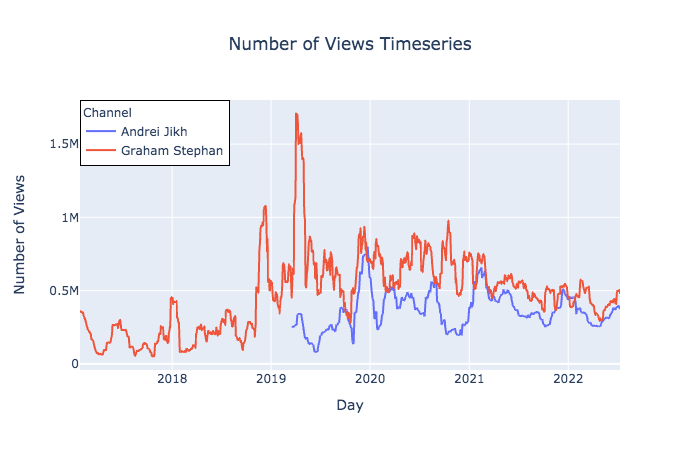

In [10]:
fig = px.line(daily_long_videos_roll,
              x="publishedAtDay", y="viewCount", color="channelTitle",
              labels={
                  "publishedAtDay": "Day",
                  "viewCount": "Number of Views",
                  "channelTitle": "Channel"
              },
              title="Number of Views Timeseries")
fig.update_layout(title_x=0.5, legend=dict(x = 0, y = 1, bordercolor = "Black", borderwidth = 1))
fig.show("png")

### Video Duration [s]

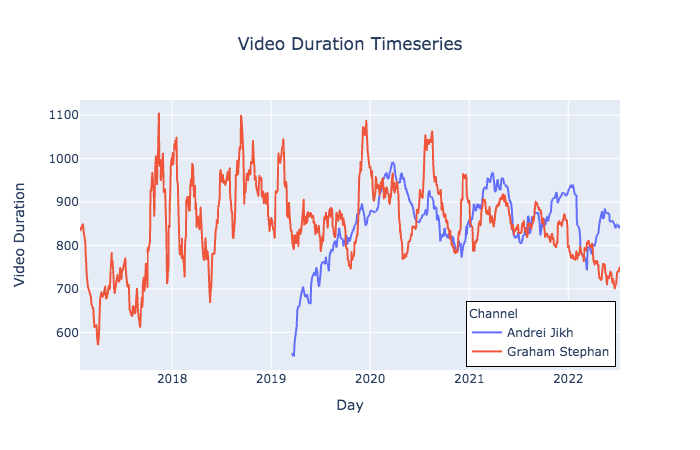

In [11]:
fig = px.line(daily_long_videos_roll,
              x="publishedAtDay", y="duration", color="channelTitle",
              labels={
                  "publishedAtDay": "Day",
                  "duration": "Video Duration",
                  "channelTitle": "Channel"
              },
              title="Video Duration Timeseries")
fig.update_layout(title_x=0.5, legend=dict(x = 0.715, y = 0.01, bordercolor = "Black", borderwidth = 1))
fig.show("png")

### Number of Comments

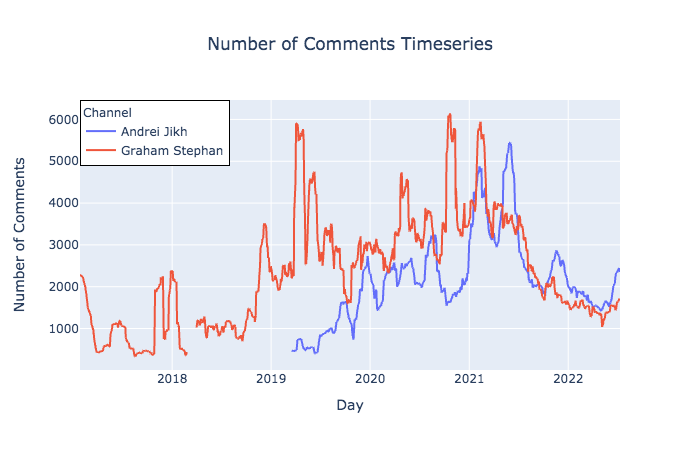

In [12]:
fig = px.line(daily_long_videos_roll,
              x="publishedAtDay", y="commentCount", color="channelTitle",
              labels={
                  "publishedAtDay": "Day",
                  "commentCount": "Number of Comments",
                  "channelTitle": "Channel"
              },
              title="Number of Comments Timeseries")
fig.update_layout(title_x=0.5, legend=dict(x = 0, y = 1, bordercolor = "Black", borderwidth = 1))
fig.show("png")

### Number of Likes

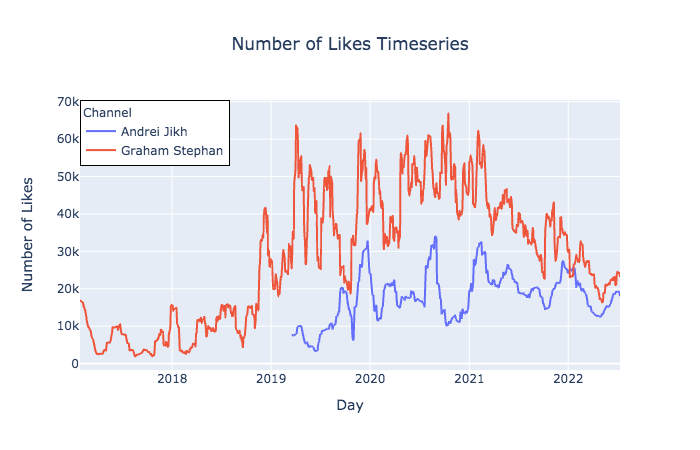

In [13]:
fig = px.line(daily_long_videos_roll,
              x="publishedAtDay", y="likeCount", color="channelTitle",
              labels={
                  "publishedAtDay": "Day",
                  "likeCount": "Number of Likes",
                  "channelTitle": "Channel"
              },
              title="Number of Likes Timeseries")
fig.update_layout(title_x=0.5, legend=dict(x = 0, y = 1, bordercolor = "Black", borderwidth = 1))
fig.show("png")

### Percentage of Interaction

Where 'Interaction' is defined by (Number of Comments / Number of Views)

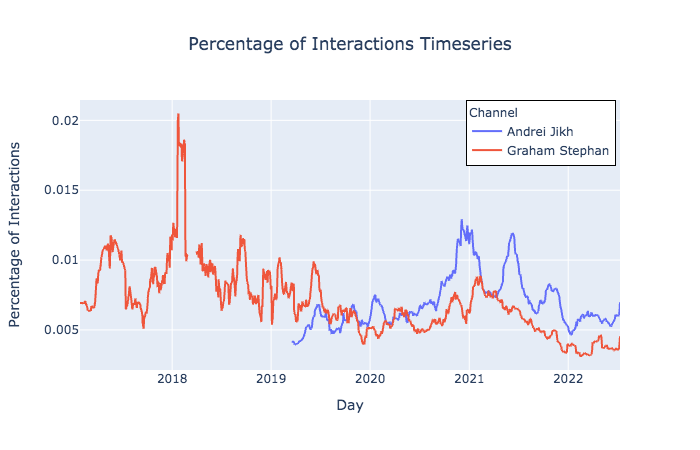

In [14]:
fig = px.line(daily_long_videos_roll,
              x="publishedAtDay", y="percInteraction", color="channelTitle",
              labels={
                  "publishedAtDay": "Day",
                  "percInteraction": "Percentage of Interactions",
                  "channelTitle": "Channel"
              },
              title="Percentage of Interactions Timeseries")
fig.update_layout(title_x=0.5, legend=dict(x = 0.715, y = 1, bordercolor = "Black", borderwidth = 1))
fig.show("png")

### Percentage of Likes

Where 'Percentage of Likes' is defined by (Number of Likes / Number of Views) 

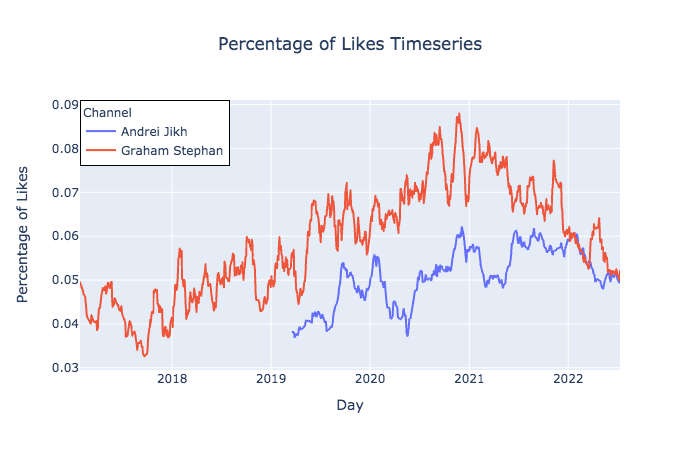

In [15]:
fig = px.line(daily_long_videos_roll,
              x="publishedAtDay", y="percLike", color="channelTitle",
              labels={
                  "publishedAtDay": "Day",
                  "percLike": "Percentage of Likes",
                  "channelTitle": "Channel"
              },
              title="Percentage of Likes Timeseries")
fig.update_layout(title_x=0.5, legend=dict(x = 0, y = 1, bordercolor = "Black", borderwidth = 1))
fig.show("png")

### Ratio between Likes and Comments

Where 'ratioLikeComment' is defined by (Number of Likes / Number of Comments)

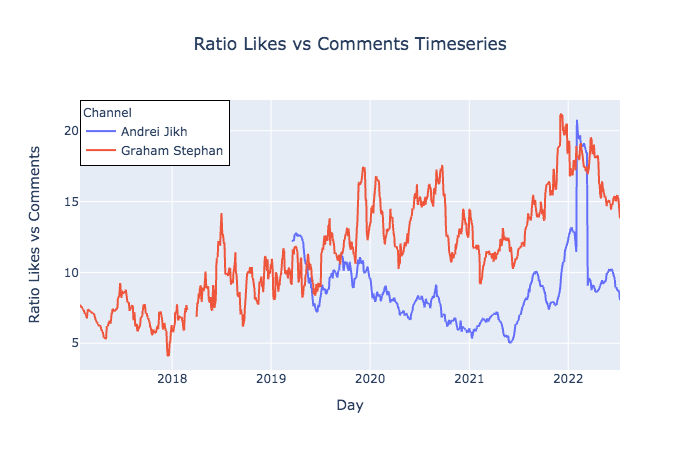

In [16]:
fig = px.line(daily_long_videos_roll,
              x="publishedAtDay", y="ratioLikeComment", color="channelTitle",
              labels={
                  "publishedAtDay": "Day",
                  "ratioLikeComment": "Ratio Likes vs Comments",
                  "channelTitle": "Channel"
              },
              title="Ratio Likes vs Comments Timeseries")
fig.update_layout(title_x=0.5, legend=dict(x = 0, y = 1, bordercolor = "Black", borderwidth = 1))
fig.show("png")

In [17]:
weekday_long_videos = long_videos.groupby(["channelTitle", "publishedAtWeekday"])[["videoId"]].count().reset_index()
weekday_videos_count = long_videos.groupby(["channelTitle"])[["videoId"]].count().reset_index().rename(columns = {"videoId": "totalVideoId"})

weekday_long_videos = weekday_long_videos.merge(weekday_videos_count, on = ["channelTitle"])
weekday_long_videos["percVideos"] = weekday_long_videos["videoId"]/weekday_long_videos["totalVideoId"]

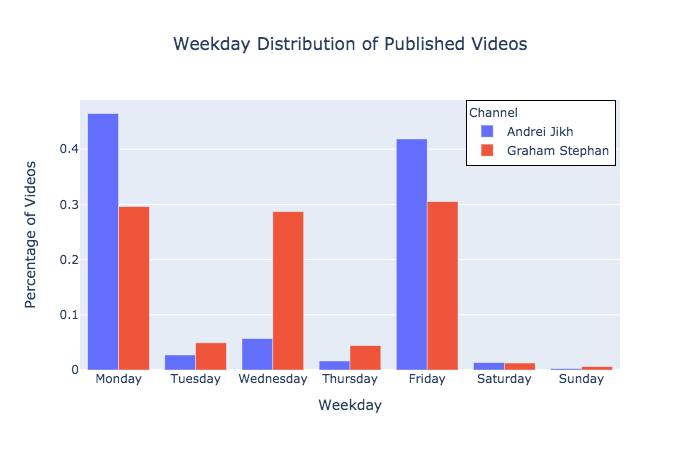

In [18]:
fig = px.bar(weekday_long_videos, x = "publishedAtWeekday", y = "percVideos",
             color = "channelTitle", barmode = "group",
             category_orders = {
                 "publishedAtWeekday":
                     ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
             },
             labels={
                 "publishedAtWeekday": "Weekday",
                 "percVideos": "Percentage of Videos",
                 "channelTitle": "Channel"
             },
             title="Weekday Distribution of Published Videos")
fig.update_layout(title_x=0.5, legend=dict(x = 0.715, y = 1, bordercolor = "Black", borderwidth = 1))
fig.show("png")